In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve, curve_fit
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

# CPN Project Task A

## Group 7

- Marco Arnold
- Hein Boonstra
- David Bender
- Lourens Olivier
- Matthew Strauss


## Task 2 – System Identification:

| System Variable         | Assigned Variable        |
|-------------------------|--------------------------|
| (1) Manipulated variable | Stem position of the valve|
| (2) Control variable     | Production rate of ammonia|
| (3) Disturbance variable | Feed Composition          |
| (4) Final control element| Valve                     |

Reasons for assigning System variable (1)-(4):
1. It can be easily controlled by adjusting the position of the valve.
2. We are told to produce high volumes of ammonia no matter what. 
3. The boss has told us the feed composition can vary and this is a disturbance. 
4. By adjusting the valve, the flowrate to the reactor (manipulated variable) changes. 

## Task 3 – System Equations and Assumptions:

#### Assumptions

The reactor tank is well mixed

Physical properties stays constant

The system is initially at steady state

K is only Temperature dependant

Flow into the reactor is dependant on the valve opening

#### Conservative Equations

\begin{aligned}
\frac{dy(t)}{dt} &= \frac{K_p P s(t)}{\tau^2} - \frac{2 \zeta y(t)}{\tau} - \frac{x(t)}{\tau^2} &...(1) \\
\frac{dx(t)}{dt} &= y(t) &...(2) \\
\frac{dC_{NH_3}}{dt} &= \frac{FC_{NH3,in}}{V} - \frac{FC_{NH3}}{V} + 2kC_{N_2}C_{H_2}^3 &...(3)\\
\frac{dC_{H_2}}{dt} &= \frac{FC_{H2,in}}{V} - \frac{FC_{H2}}{V} - 3kC_{N_2}C_{H_2}^3 &...(4)\\
\frac{dC_{N_2}}{dt} &= \frac{FC_{N2,in}}{V} - \frac{FC_{N2}}{V} - kC_{N_2}C_{H_2}^3 &...(5)\\
\end{aligned}

#### Constitutive equations
\begin{aligned}
F &= C_{cv} f(x(t))\sqrt{\frac{\Delta P_{CV}}{SG}} &...(6)\\
f(x(t)) &= \sqrt{x(t)} &...(7)\\
k &= k_0 e^{-\frac{E_a}{RT}} &...(8)
\end{aligned}

#### DOF

Independant equations include: Equations 1, 2, 3, 6, 7, 8 = 6 Equations in total

Unknowns include: y(t), k, F, Ps(t), f(x(t)), CNH3 = 6 Unknowns in total

DOF = NV - NE = 6 - 6 = 0

System is exactly specified
                              

## Task 4 – Steady State Calculations Using Python:

In [2]:
#-----------------------------------Calculating volumetric flow----------------------------------------------
MM = np.array([14.0067*2, 1.00784*2])
molar_fractions = np.array([0.25, 0.75])
MM_mix = MM[0]*molar_fractions[0] + MM[1]*molar_fractions[1]   #g/mol
molar_flow = 1304.85    #mol/s from Task 1
mass_flow = molar_flow*MM_mix / 1000   #kg/s
density_mix = 8.81609     #kg/m^3 from Task 1
volumetric_flow = mass_flow/density_mix #m^3/s

#------------------------------------------Known variables----------------------------------------------------
V = 1
k0 = 0.0001
Ea = 60000
R = 8.314
T = 1140   #from Task 1
k = k0*np.exp(-Ea/(R*T))
F = volumetric_flow
CN2_in = molar_flow * molar_fractions[0] / F
CH2_in = molar_flow * molar_fractions[1] / F
CNH3_in = 0

#------------------------------------------Using fsolve------------------------------------------------------
def solve(y):
    CN2, CH2, CNH3 = y
    eqn1 = F*CN2_in/V - F*CN2/V - k*CN2*CH2**3
    eqn2 = F*CH2_in/V - F*CH2/V - 3*k*CN2*CH2**3
    eqn3 = F*CNH3_in/V - F*CNH3/V + 2*k*CN2*CH2**3
    return eqn1, eqn2, eqn3
guess = [CN2_in/2, CH2_in/2, CN2_in*2]   #Guess values are chosen which should be within the acceptable range based on reaction stoichiometry
CN2_ss, CH2_ss, CNH3_ss = fsolve(solve,guess)
print("SS conc N2 = {} mol/m^3, SS conc H2 = {} mol/m^3, SS conc NH3 = {} mol/m^3".format(round(CN2_ss,2), round(CH2_ss,2), round(CNH3_ss,2)))
print('SS molar flow N2 = {} mol/s, SS molar flow H2 = {} mol/s, SS molar flow NH3 = {} mol/s'. format(round(CN2_ss*F,2), round(CH2_ss*F,2), round(CNH3_ss*F,2)))

SS conc N2 = 82.45 mol/m^3, SS conc H2 = 247.36 mol/m^3, SS conc NH3 = 352.76 mol/m^3
SS molar flow N2 = 103.92 mol/s, SS molar flow H2 = 311.75 mol/s, SS molar flow NH3 = 444.59 mol/s


### The results of the above calculations are given in the table below 


| Variable              | Value   | Units    |
|-----------------------|---------|----------|
| Concentration of N2   | 82.45  | mol/m³   |
| Concentration of H2   | 247.36 | mol/m³   |
| Concentration of NH3  | 352.76 | mol/m³   |
| Flow rate             | 1.260   | m³/s     |

## Task 5 – Steady State Simulation Using DWSIM:

|     Variable      |  Python  | DWSIM value |     Units     |
|:-----------------:|:--------:|:-----------:|:-------------:|
| Molar flow of N2  |  103.92  |    103.90   |    mole/s     |
| Molar flow of H2  |  311.75  |    311.70   |    mole/s     |
| Molar flow of NH3 |  444.59  |    444.63   |    mole/s     |
|    Flow rate      |   1.26   |      0.83   |      m3/s     |

Conversion used in DWSIM is 68.15%


## Task 6 – Transient System Response:

In [3]:
#------------------------------------------Known variables------------------------------------------------------
tau = 10   #s
Kp = 1/12
zeta = 3
P_initial = 9
del_P = 2
#----------------------------------------Initial calculations---------------------------------------------------
x_initial = Kp*P_initial
SG = density_mix / 997
Cv = volumetric_flow / np.sqrt(x_initial) / np.sqrt(2/SG)
#------------------------------------------Chosen variables-----------------------------------------------------
M = 4   #Chosen step change in pressure
t_end = 400  #Time to integrate to
steps = 10000    #Steps for integration
t_step_change = 50    #Time at which the pressure undergoes a step change

#--------------------------Solver function-----------------------------------------------------
def euler_solver(t_end, steps, t_step_change, M):
#------------------------------------------Initialize values----------------------------------------------------    
    times = np.linspace(0, t_end, steps)
    dt = times[1] - times[0]
    Ps = np.zeros(len(times))    #These arrays will be updated in the for loop
    x = np.zeros(len(times))    #These arrays will be updated in the for loop
    y = np.zeros(len(times))    #These arrays will be updated in the for loop
    Fs = np.zeros(len(times))    #These arrays will be updated in the for loop
    CN2 = np.zeros(len(times))    #These arrays will be updated in the for loop
    CH2 = np.zeros(len(times))    #These arrays will be updated in the for loop
    CNH3 = np.zeros(len(times))    #These arrays will be updated in the for loop
    
    Ps[0] = P_initial     #The initial conditions can be changed outside the function
    x[0] = x_initial     #The initial conditions can be changed outside the function
    y[0] = 0     #The initial conditions can be changed outside the function
    Fs[0] = volumetric_flow     #The initial conditions can be changed outside the function
    CN2[0] = CN2_ss     #The initial conditions can be changed outside the function
    CH2[0] = CH2_ss     #The initial conditions can be changed outside the function
    CNH3[0] = CNH3_ss     #The initial conditions can be changed outside the function
#--------------------------------------------For loop-----------------------------------------------------------   
    for i in range(0, len(times)-1):
#----------------------------------Get pressures with step change-----------------------------------------------        
        if times[i] <= t_step_change:
            Ps[i+1] = P_initial
        else:
            Ps[i+1] = P_initial + M
#-----------------------------------------Solve for x values---------------------------------------------------           
        dxdt = y[i]
        dydt = -2*zeta/tau*dxdt - x[i]/tau**2 + Kp*Ps[i]/tau**2 
        x[i+1] = x[i] + dxdt*dt
        y[i+1] = y[i] + dydt*dt
#----------------------------------------Calculating flowrate--------------------------------------------------
        Fs[i+1] = Cv * x[i+1]**0.5 * np.sqrt(2/SG)
#--------------------------------------Solve for concentrations------------------------------------------------
        dcn2dt = Fs[i]*(CN2_in - CN2[i]) - k*CN2[i]*CH2[i]**3
        dch2dt = Fs[i]*(CH2_in - CH2[i]) - 3*k*CN2[i]*CH2[i]**3
        dcnh3dt = Fs[i]*(CNH3_in - CNH3[i]) + 2*k*CN2[i]*CH2[i]**3
        CN2[i+1] = CN2[i] + dcn2dt*dt
        CH2[i+1] = CH2[i] + dch2dt*dt
        CNH3[i+1] = CNH3[i] + dcnh3dt*dt
    
    return times, Ps, x, Fs, CN2, CH2, CNH3

times, Ps, x, Fs, CN2, CH2, CNH3 = euler_solver(t_end, steps, t_step_change, M)

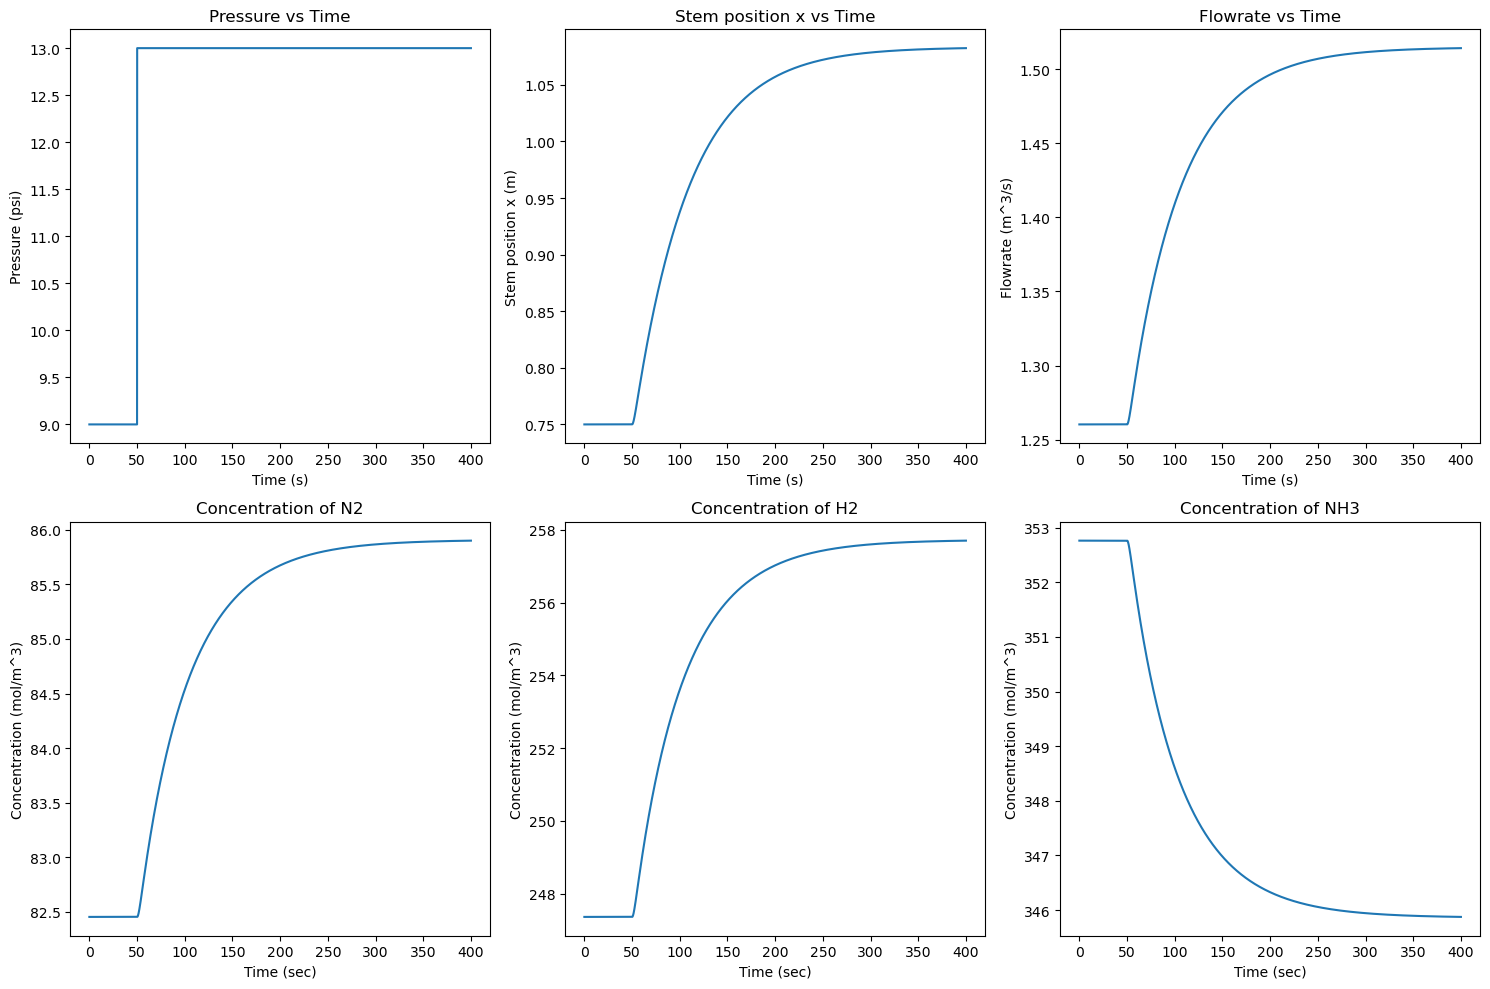

In [4]:
#----------------------------------------Plotting the results--------------------------------------------------
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].plot(times, Ps)
axs[0, 0].set_title("Pressure vs Time")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Pressure (psi)")
axs[0, 1].plot(times, x)
axs[0, 1].set_title("Stem position x vs Time")
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Stem position x (m)")
axs[0, 2].plot(times, Fs)
axs[0, 2].set_title("Flowrate vs Time")
axs[0, 2].set_xlabel("Time (s)")
axs[0, 2].set_ylabel("Flowrate (m^3/s)")
axs[1, 0].plot(times, CN2)
axs[1, 0].set_title("Concentration of N2")
axs[1, 0].set_xlabel("Time (sec)")
axs[1, 0].set_ylabel("Concentration (mol/m^3)")
axs[1, 1].plot(times, CH2)
axs[1, 1].set_title("Concentration of H2")
axs[1, 1].set_xlabel("Time (sec)")
axs[1, 1].set_ylabel("Concentration (mol/m^3)")
axs[1, 2].plot(times, CNH3)
axs[1, 2].set_title("Concentration of NH3")
axs[1, 2].set_xlabel("Time (sec)")
axs[1, 2].set_ylabel("Concentration (mol/m^3)")

plt.tight_layout()
plt.show()

## Task 7 – FOPDT Fitting and Determination of Kp, Tau and Theta:

In [5]:
#------------------------------------------FOPDT function----------------------------------------------------
def FOPDT(t, Kp, tau, theta):
    C_vals = []
    for i in t:
        if i<=theta:
            C_vals.append(Cs)
        if i>theta:
            C = Kp*M*(1-np.exp(-(i-theta)/tau)) + Cs
            C_vals.append(C)
    return np.array(C_vals)
#-------------------------------------------Guess values------------------------------------------------------
Cs = CNH3[0]
Kp_guess = (CNH3[-1] - Cs)/M
tau_guess = 80     #Calculated by finding the time at which the concentration = Cs + 0.63*delta
theta_guess = 50
#-----------------------------------Solving for KP, tau and theta---------------------------------------------
params,_ = curve_fit(FOPDT,times,CNH3,p0=[Kp_guess, tau_guess, theta_guess])
Kp, tau, theta_total = params
theta = theta_total - t_step_change     #The overall deadtime needs to be subtracted to get the theta value for the concentratino response. 
FOPDT_flows = FOPDT(times, Kp, tau, theta_total)   #Now calculate the flows predicted by the FOPDT method. 
                                                   #Note we use theta_total as we need to take into account overall deadtime.

### The values of Kp, tau and theta are given in the table below


|   Variable    | Calculated value |  Units  |
|:-------------:|:----------------:|:-------:|
|      Kp       |      -1.866      |         |
|      Tau      |      55.634      |    s    |
|     Theta     |       1.304      |    s    |



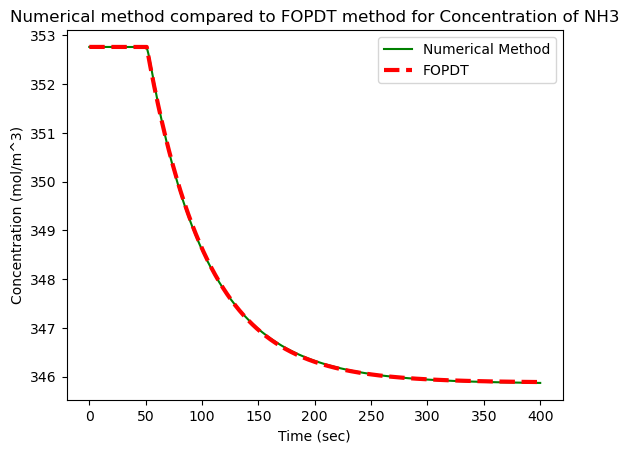

In [6]:
plt.figure()
plt.title("Numerical method compared to FOPDT method for Concentration of NH3")
plt.xlabel("Time (sec)")
plt.ylabel("Concentration (mol/m^3)")
plt.plot(times,CNH3,'g',label='Numerical Method')
plt.plot(times,FOPDT_flows,'r--',label='FOPDT',linewidth=3)
plt.legend(loc='best')
plt.show()

In [64]:
import pandas as pd

csv_file_path = '/Users/matt/Desktop/Laplace data scilab.csv'

laplace_data = np.matrix(pd.read_csv(csv_file_path))


Text(0, 0.5, 'Concentration (mol/m^3)')

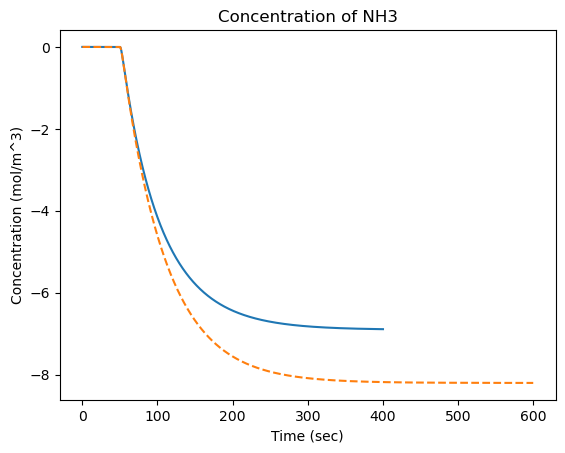

In [65]:
plt.figure(1)
plt.plot(times, CNH3-CNH3_ss, label="Euler")
plt.plot(laplace_data[:,0], laplace_data[:,1], "--", label="Linearised model")
plt.title("Concentration of NH3")
plt.xlabel("Time (sec)")
plt.ylabel("Concentration (mol/m^3)")